# Image classification with Swin Transformers

**Author:** [Rishit Dagli](https://twitter.com/rishit_dagli)<br>
**Date created:** 2021/09/08<br>
**Last modified:** 2021/09/08<br>
**Description:** Image classification using Swin Transformers, a general-purpose backbone for computer vision.

This example implements [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a general-purpose backbone
for computer vision. Swin Transformer is a hierarchical Transformer whose
representations are computed with _shifted windows_. The shifted window scheme
brings greater efficiency by limiting self-attention computation to
non-overlapping local windows while also allowing for cross-window connections.
This architecture has the flexibility to model information at various scales and has
a linear computational complexity with respect to image size.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Addons,
which can be installed using the following commands:

In [1]:
!pip install -U tensorflow-addons

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

c:\Users\PC\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import os

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to `(1, 1)`.
Below, we take inspiration from the original paper settings
for training on ImageNet-1K, keeping most of the original settings for this example.

In [5]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 128  # Initial image size
input_shape = (image_dimension, image_dimension, 3)
num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
num_epochs = 50
weight_decay = 0.0001
label_smoothing = 0.1

SPLIT_SEED = 198
num_classes = 268

## Getting Data (If it is saved earlier)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
pathh='C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\Veriler\\hepsi\\5\\128'
y_train_aug_le= np.loadtxt(pathh+'/y_train_aug_le.txt', dtype=float)
y_train_aug_cat= np.loadtxt(pathh+'/y_train_aug_cat.txt', dtype=float)
y_val_le= np.loadtxt(pathh+'/y_val_le.txt', dtype=float)
y_val_cat= np.loadtxt(pathh+'/y_val_cat.txt', dtype=float)
y_test_le= np.loadtxt(pathh+'/y_test_le.txt', dtype=float)
y_test_cat= np.loadtxt(pathh+'/y_test_cat.txt', dtype=float)
x_train= np.load(pathh+'/x_train.npy')
x_val= np.load(pathh+'/x_val.npy')
x_test= np.load(pathh+'/x_test.npy')
y_test= np.load(pathh+'/y_test.npy')
y_val= np.load(pathh+'/y_val.npy')
y_train= np.load(pathh+'/y_train.npy')

## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [8]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships between
a token and all other tokens are computed. The global computation leads to quadratic
complexity with respect to the number of tokens. Here, as the [original paper](https://arxiv.org/abs/2103.14030)
suggests, we compute self-attention within local windows, in a non-overlapping manner.
Global self-attention leads to quadratic computational complexity in the number of patches,
whereas window-based self-attention leads to linear complexity and is easily scalable.

In [9]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard multi-head
attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [10]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [11]:

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### Build the model

We put together the Swin Transformer model.

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(rescale_dim, rescale_dim),
        # layers.RandomFlip("horizontal_and_vertical"),
        # layers.RandomRotation(factor=0.02),
        # layers.GaussianNoise(0.3),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [13]:
input = layers.Input(input_shape)
x = data_augmentation(input)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [14]:
from datetime import datetime

model = keras.Model(input, output)

for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        tfa.metrics.CohenKappa(num_classes=268, sparse_labels=False)
    ],
)

kayit_adresi = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\grad_modeller\\Image classification with Swin Transformers-20230521T093746Z-001\\Image classification with Swin Transformers\\model_kayitlari"
if not os.path.exists(kayit_adresi):
    os.mkdir(kayit_adresi)
zaman = datetime.today().strftime('%d-%m-%Y-%H-%M')
model_kayit_noktasi_adresi = os.path.join(kayit_adresi,zaman)
os.mkdir(model_kayit_noktasi_adresi)

# kayit adresleri
checkpoint_filepath  = os.path.join(model_kayit_noktasi_adresi,"sel.hdf5")

# Delete existing file
if os.path.exists(checkpoint_filepath):
    os.remove(checkpoint_filepath)

# CHECKPOINT
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = checkpoint_filepath,
save_weights_only = True,
monitor='val_accuracy',
save_best_only = True)

# LRR
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  
factor=.1,  # Factor by which learning rate will be reduced
patience=20,
min_lr=1e-5)
callbacks = [ checkpoint_callback, lrr]


history = model.fit(
    x=x_train,
    y=y_train_aug_cat,
    epochs=num_epochs,
    batch_size=64,
    validation_data=(x_val,y_val_cat),
    callbacks=callbacks
)


Epoch 1/50
274/274 [==============================] - 78s 273ms/step - loss: 4.5790 - accuracy: 0.1093 - top-5-accuracy: 0.2968 - cohen_kappa: 0.0930 - val_loss: 4.2656 - val_accuracy: 0.1425 - val_top-5-accuracy: 0.3647 - val_cohen_kappa: 0.1342 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 73s 265ms/step - loss: 3.8908 - accuracy: 0.2174 - top-5-accuracy: 0.4937 - cohen_kappa: 0.2053 - val_loss: 3.7146 - val_accuracy: 0.2251 - val_top-5-accuracy: 0.5584 - val_cohen_kappa: 0.2189 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - 71s 260ms/step - loss: 3.5319 - accuracy: 0.3064 - top-5-accuracy: 0.6017 - cohen_kappa: 0.2965 - val_loss: 3.3274 - val_accuracy: 0.3533 - val_top-5-accuracy: 0.6781 - val_cohen_kappa: 0.3493 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 70s 257ms/step - loss: 3.2620 - accuracy: 0.3788 - top-5-accuracy: 0.6743 - cohen_kappa: 0.3705 - val_loss: 3.1340 - val_accuracy: 0.4160 - val_top-5-accuracy: 0.6980

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

#Load the predicted labels and true labels
y_pred = model.predict(x_test)  # Load your predicted labels
y_true = y_test  # Load your true labels

#Create the confusion matrix
cm = confusion_matrix(y_true, y_pred.argmax(axis=-1))

tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

arr_replaced = np.nan_to_num(f1, nan=0)
#Print the F1 score
print("F1 Score:", np.mean(arr_replaced))

11/11 [==============================] - 1s 28ms/step
F1 Score: 0.608063847429519


C:\Users\PC\AppData\Local\Temp\ipykernel_6324\1454713841.py:15: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\PC\AppData\Local\Temp\ipykernel_6324\1454713841.py:17: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
loss, accuracy, top_5_accuracy, kappa_score = model.evaluate(x_test, y_test_cat)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
print(f"Kappa Score:{kappa_score}")

In [78]:
txt_kayit_adresi    = os.path.join(model_kayit_noktasi_adresi, f"agumentasyon_modeli.txt")
try:
    with open(txt_kayit_adresi, "w") as fh:
        fh.write(f"Epok sayisi: {num_epochs}\nbasarisi: Test accuracy: {round(accuracy * 100, 2)}%\nCohenKappa Skoru: {kappa_score}\nF1 Skor: {np.mean(arr_replaced)}\nResim Boyutu: {image_dimension}\nPatch Boyutu: {patch_size}\nTest top 5 accuracy: {round(top_5_accuracy * 100, 2)}%\n loss='categorical_crossentropy' metrics=['accuracy']\n")
        data_augmentation.summary(print_fn=lambda x: fh.write(x + '\n'))

except Exception as e2:
    print("Model txt ye yazdirilamadi, hata: ", e2)

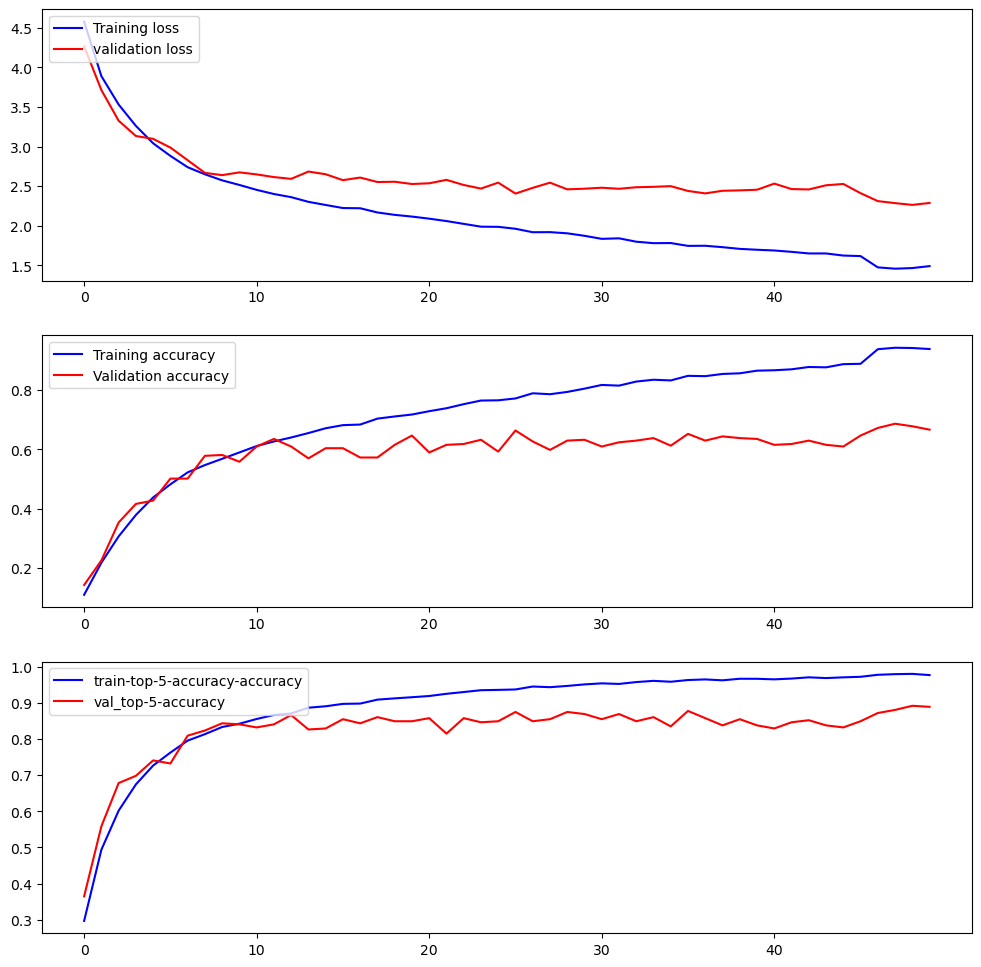

In [79]:
grafik_adresi = os.path.join(model_kayit_noktasi_adresi, "Grafik.png")

try:
        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(0, num_epochs, 10))
    ax1.legend(loc='upper left')

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(0, num_epochs, 10))
    ax2.legend(loc='upper left')

    ax3.plot(history.history['top-5-accuracy'], color='b',label="train-top-5-accuracy-accuracy")
    ax3.plot(history.history['val_top-5-accuracy'], color='r',label="val_top-5-accuracy")
    ax3.set_xticks(np.arange(0, num_epochs, 10))
    ax3.legend(loc='upper left')
    plt.savefig(grafik_adresi, bbox_inches='tight', facecolor='w')
    plt.show()

except Exception as e:
    print(f"Grafik çizilemedi {e}")